In [174]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ECGs_function import *
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## Data Importation

In [2]:
Xtrain,Ytrain,Xtest = DataImporting()
lable = Ytrain.TARGET.values

# Méthodologie

Notre méthode contient des parties suivantes :


* $Collection\ des\ variables$

    Elles sont obtenues par des transformations ou des connaisances a priori, c-à-d, par l'hypothèse que l'on pense sur où se trouve les informations utiles.


* $Sélection\ des\ variable$

    En général, on a fait deux types de sélection :
        
        * par SelectKBest
        * par la connaisance a priori et la performance de test(détailles dans la suite)

* $Sélection\ des\ classifieurs$



* $Ajustement\ de\ la\ méthode\ de\ sélection\ des\ variables\ et\ les\ paramètres\ du\ classifieur$



* $Test\ par\ validation\ croisée$

#### Remarque :

Les variables sélectionnés sont mis dans une matrice $SelectedFeatures$, et on peut compiler directement les classifieurs différents pour obtenir les scores.



# I. Analyse Préliminaire


## I.1 DataSample 

On va définir la fonction DataSample(se trouve dans ECG_function.py) pour extraire les données par id(individu) et channel(chaîne).

In [3]:
#Test
DataSample(Xtrain,[1,2],3)

,ML3_0,ML3_1,ML3_2,ML3_3,ML3_4,ML3_5,ML3_6,ML3_7,ML3_8,ML3_9,...,ML3_740,ML3_741,ML3_742,ML3_743,ML3_744,ML3_745,ML3_746,ML3_747,ML3_748,ML3_749
1,0.000368,-0.002160,-0.004497,-0.006134,-0.005459,-0.003844,-0.003149,-0.004335,-0.006095,-0.006248,...,-0.004131,-0.003545,-0.002869,-0.002309,-0.001962,-0.001751,-0.001515,-0.001043,-0.000220,0.000895
2,0.016568,0.037517,0.035063,0.035143,0.036901,0.036132,0.036647,0.036375,0.035232,0.033861,...,-0.066095,-0.030852,0.029556,0.046187,0.044581,0.042301,0.050770,0.070837,0.084942,0.086189


## I.2 Interprétations Graphiques

#### TARGET = 0

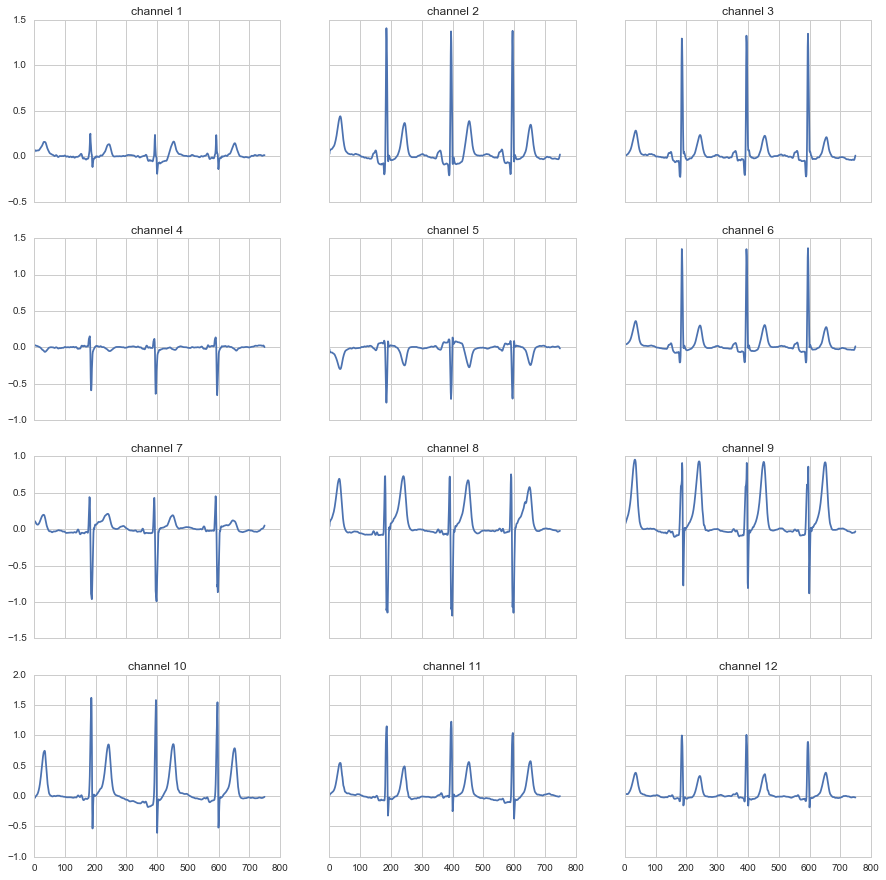

In [4]:
id = 4
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6),(ax7, ax8, ax9), (ax10, ax11,ax12)) = plt.subplots(4, 3, sharex='col', sharey='row')
fig.set_size_inches(15, 15)

for (ax,i) in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12),range(1,13,1)):
    ax.plot(DataSample(Xtrain,id,i).values)
    ax.set_title('channel '+str(i))
    

#### TARGET = 1

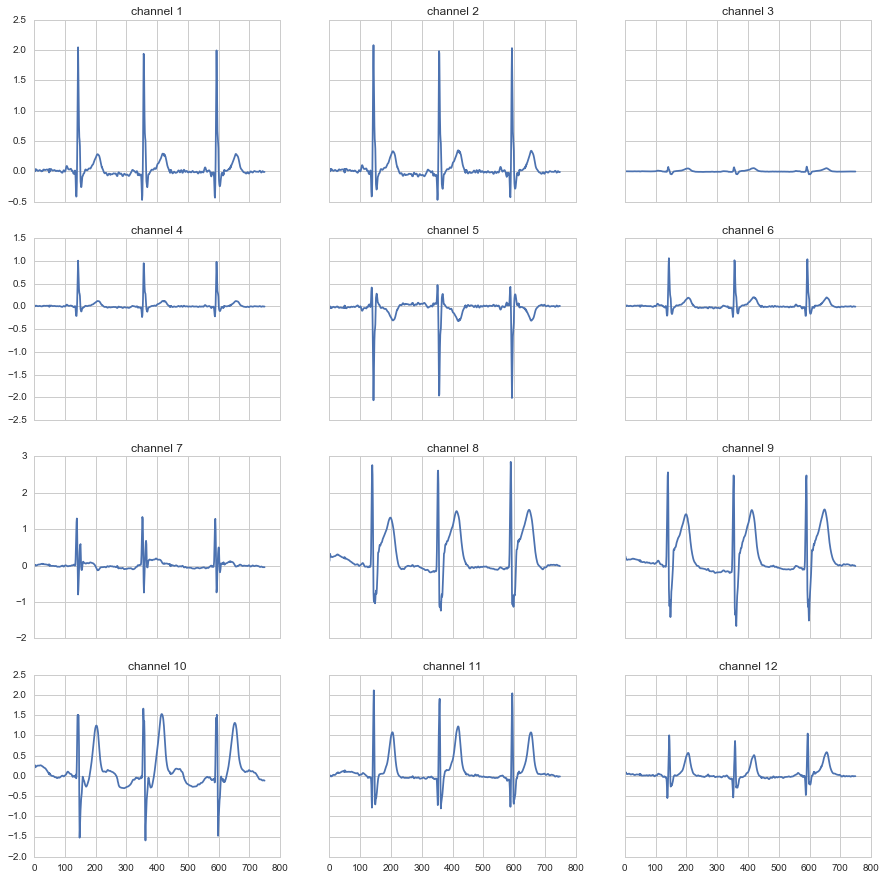

In [5]:
id = 0
fig, ((ax1, ax2, ax3), (ax4, ax5,ax6),(ax7, ax8, ax9), (ax10, ax11,ax12)) = plt.subplots(4, 3, sharex='col', sharey='row')
fig.set_size_inches(15, 15)

for (ax,i) in zip((ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12),range(1,13,1)):
    ax.plot(DataSample(Xtrain,id,i).values)
    ax.set_title('channel '+str(i))
    

# II. Collection et Transformation des Variables

In [68]:
AllFeatures = [[] for id in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures[id] += list(DataSample(Xtrain,id,k+1).values)

## II.1 Analyse en composantes principales (PCA)

In [71]:
from sklearn.decomposition import PCA
var_explained = []
channel = 1
for num_pca in range(100,1200,100):
    
    pca = PCA(n_components = num_pca)
    pca.fit(AllFeatures)
    var_explained += [np.sum(pca.explained_variance_ratio_)]



([<matplotlib.axis.XTick at 0x14d875c10>,
 <a list of 11 Text xticklabel objects>)

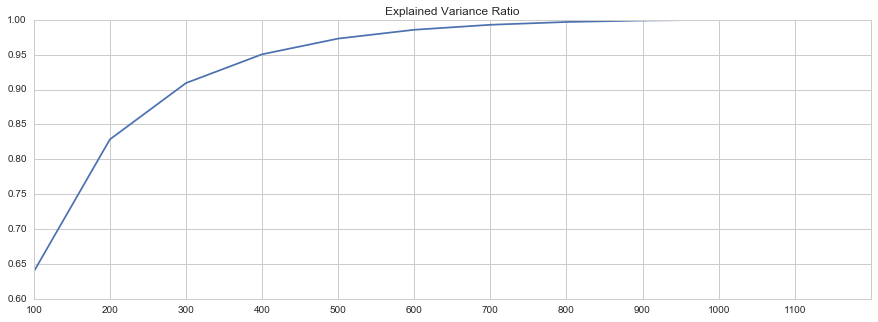

In [91]:
plt.figure(figsize = [15,5])
plt.plot(var_explained)
plt.title('Explained Variance Ratio')
plt.xticks(range(0,12),range(100,1200,100))

Selon le plot, on choisit num_pca = 1000

In [73]:
pca = PCA(n_components = 1000)
pca.fit(AllFeatures)
AllFeatures_pca = pca.transform(AllFeatures)

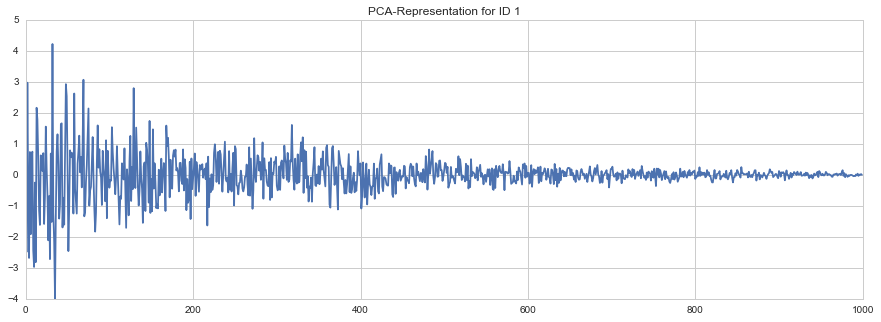

In [8]:
id = 2
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_pca[id])
plt.title("PCA-Representation for ID 1")

### ACP par channel (channel = 1)

In [75]:
from sklearn.decomposition import PCA
var_explained_channel = []
channel = 1
for num_pca in range(50,750,50):
    
    pca = PCA(n_components = num_pca)
    pca.fit(DataSample(Xtrain,range(1000),channel))
    var_explained_channel += [np.sum(pca.explained_variance_ratio_)]


([<matplotlib.axis.XTick at 0x149b1ed10>,
 <a list of 14 Text xticklabel objects>)

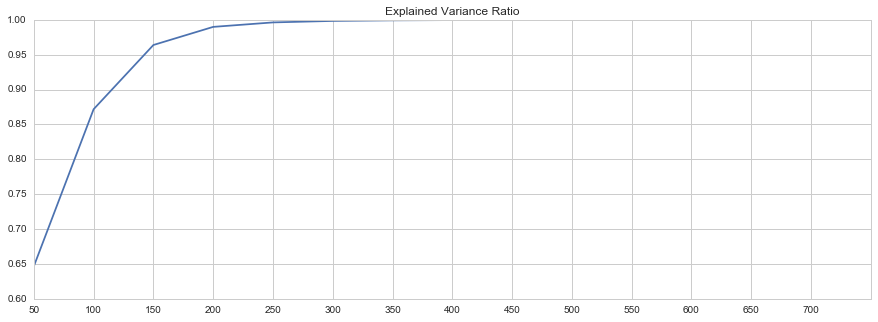

In [90]:
plt.figure(figsize = [15,5])
plt.plot(var_explained_channel)
plt.title('Explained Variance Ratio')
plt.xticks(range(0,15),range(50,750,50))

In [85]:
AllFeatures_pca_channel = [[[] for k in range(12)]for id in range(1000)]
num_pca = 100
for channel in range(12):
    pca = PCA(n_components = num_pca)
    pca.fit(DataSample(Xtrain,range(1000),channel+1))
    for id in range(1000):
        AllFeatures_pca_channel[id][channel] = pca.transform(DataSample(Xtrain,id,channel+1))[0]
    

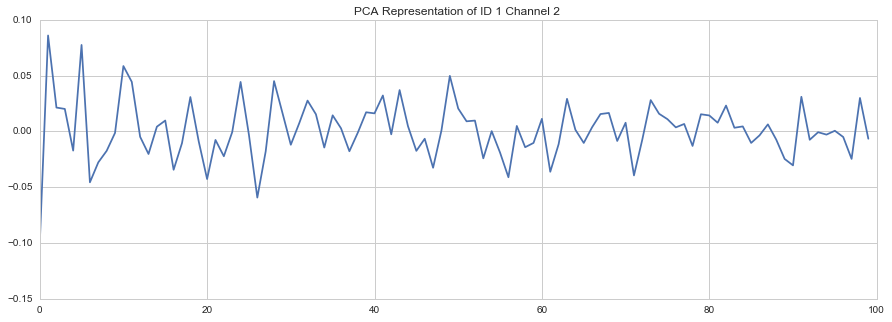

In [98]:
plt.figure(figsize=[15,5])
plt.plot(AllFeatures_pca_channel[1][2])
plt.title("PCA Representation of ID 1 Channel 2 ")

## II.2 Transformation de Fourier (FFT)

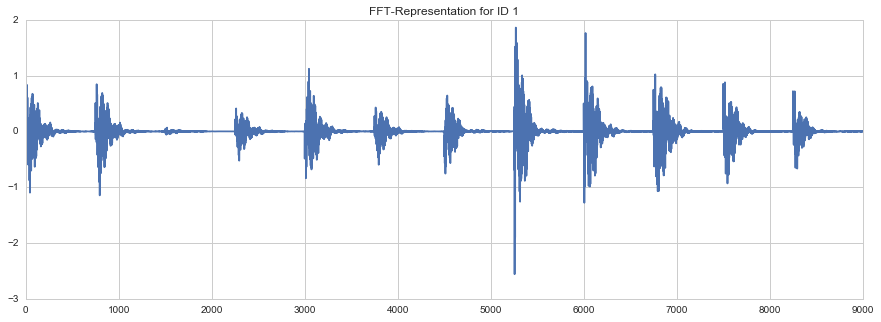

In [183]:
from scipy.fftpack import dct, idct

AllFeatures_fft =[[] for i in range(1000)]

for id in range(1000):
    for k in range(1,13):
        AllFeatures_fft[id] += list(dct(DataSample(Xtrain,id,k).values, norm='ortho'))
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_fft[1])
plt.title("FFT-Representation for ID 1")

### Si on ne conserve que les [0:30]

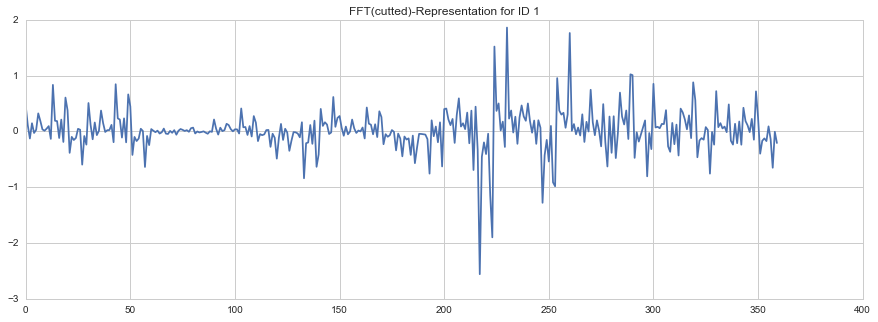

In [10]:
from scipy.fftpack import dct, idct

AllFeatures_fft_cutted =[[] for i in range(1000)]

for id in range(1000):
    for k in range(1,13):
        AllFeatures_fft_cutted[id] += list(dct(DataSample(Xtrain,id,k).values, norm='ortho'))[0:30]
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_fft_cutted[1])
plt.title("FFT(cutted)-Representation for ID 1")

## II.3 Transformation en Ondelette (dwt)

In [11]:
import pywt

def WaveletExtraction(id,k): 
    a = list(pywt.dwt(DataSample(Xtrain,id,k+1).values, 'db2'))[0]
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    a = list(pywt.dwt(a,'db2')[0])
    return a

AllFeatures_dwt =[[] for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_dwt[id] += WaveletExtraction(id,k)

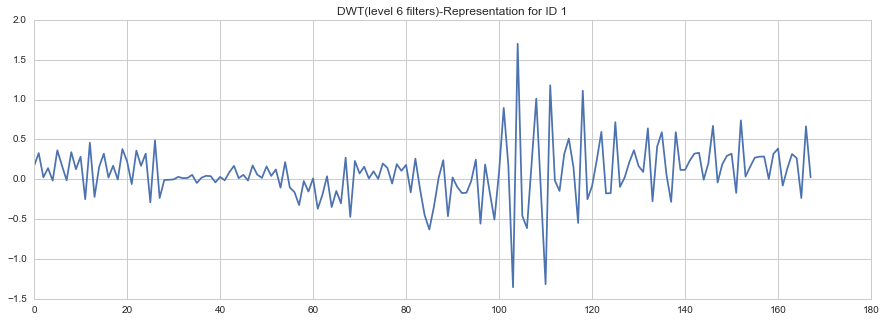

In [12]:
plt.figure(figsize=(15,5))
plt.plot(AllFeatures_dwt[1])
plt.title("DWT(level 6 filters)-Representation for ID 1")

## II.4 "PEAKS" Extraction

Nombre de peaks :  88


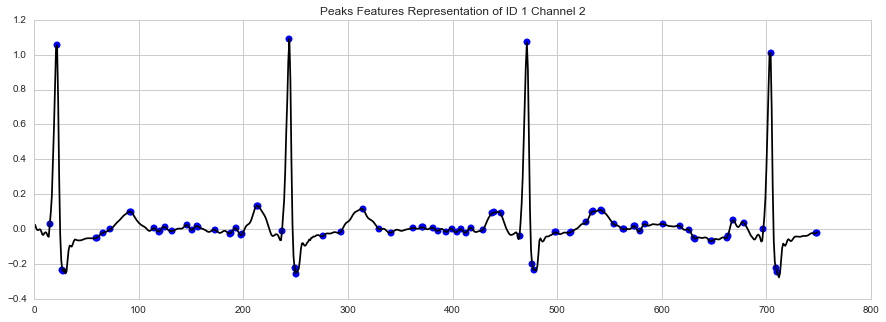

In [13]:
id = 1
channel = 2
test = DataSample(Xtrain,id,channel).values 
from scipy import signal
sig_cwt = list(signal.cwt(test, signal.ricker,np.arange(1,15)))[5]
points_positive = signal.find_peaks_cwt(test,np.arange(2,4))
points_negative = signal.find_peaks_cwt(-test,np.arange(2,4))
points = points_positive+points_negative
def f(x):
    return test[x]


plt.figure(figsize = [15,5])
plt.plot(points, f(points),'bo',range(750),f(range(750)),'k')
plt.title("Peaks Features Representation of ID 1 Channel 2")
print "Nombre de peaks : ", len(points)

#### On peut aussi ajouter une seuil pour enlever tous les "petit peaks". 


In [14]:
def PeakFeature(wave):
    points_positive = signal.find_peaks_cwt(wave,np.arange(2,4))
    points_negative = signal.find_peaks_cwt(-wave,np.arange(2,4))
    points = points_positive+points_negative
    threshold = 0.2*np.std(sorted([wave[i] for i in points]))
    peak_feature = [0 for i in range(len(wave))]
    for i in points:
        if np.abs(wave[i]) > threshold:
            peak_feature[i] = wave[i]
#     for i in points:
#         peak_feature[i] = wave[i]
    return peak_feature

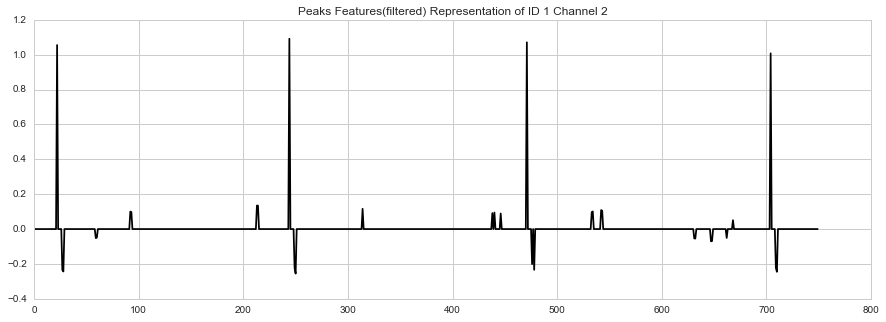

In [15]:
plt.figure(figsize = [15,5])
plt.plot(PeakFeature(test),c = 'black')
plt.title("Peaks Features(filtered) Representation of ID 1 Channel 2")

In [16]:
# AllFeatures_peaks = [[[]for k in range(12)]for id in range(1000)]
# for id in range(1000):
#     for k in range(12):
#         AllFeatures_peaks[id][k] = PeakFeature(DataSample(Xtrain,id,k+1).values)

In [17]:
# import cPickle
# myBigList = AllFeatures_peaks
# savefilePath = 'sample data/AllFeatures_peaks.csv'
# with open(savefilePath, 'w') as savefile:
#   cPickle.dump(AllFeatures_peaks, savefile)

In [18]:
import cPickle
savefilePath = 'sample data/AllFeatures_peaks.csv'
with open(savefilePath) as savefile:
  AllFeatures_peaks = cPickle.load(savefile)

# III. Sélection de Variables

## III.1 SelectKBest (ANOVA ou F-test)

On va couper l'ensemble en deux parties, une pour l'apprentissage et l'autre pour le test.

AllFeatures_collected est les variables collecté.

In [184]:
from sklearn.feature_selection import SelectKBest, f_classif
N_sep = len(lable)*2/3

AllFeatures_collected = AllFeatures_fft
num_features = 330

Select = SelectKBest(f_classif, k=num_features)
Select.fit(AllFeatures_collected[0:N_sep], lable[0:N_sep])
SelectedFeatures = Select.transform(AllFeatures_collected)

np.shape(SelectedFeatures)


(1000, 330)

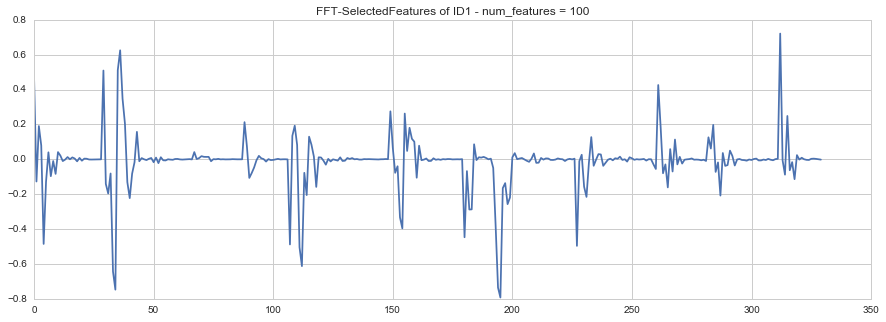

In [185]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])
plt.title('FFT-SelectedFeatures of ID1 - num_features = 100')

## III.2 Sélection à la main. (max abs)


### III.1 Sélection de PCA

#### III.1.1 Découpage Direct

In [247]:
SelectedFeatures = [[] for i in range(1000)]
num_composant = 5

for i in range(1000):
    for k in range(12):

        SelectedFeatures[i] += [AllFeatures_pca_channel[i][k][j] for j in range(num_composant)]
        

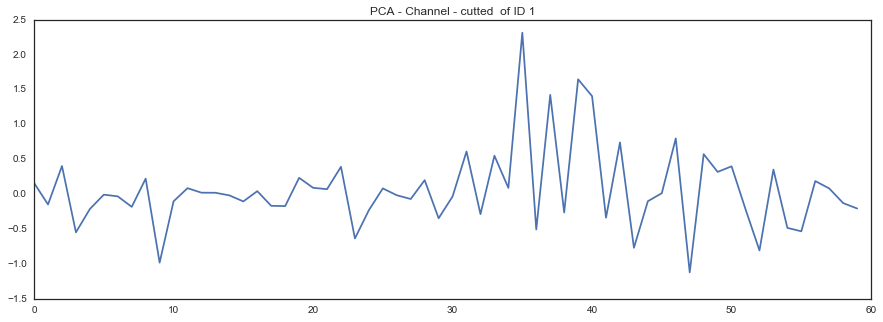

In [248]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])
plt.title("PCA - Channel - cutted  of ID 1")

#### III.1.2 Max-abs

In [229]:
AllFeatures_pca_channel_sorted = [[[] for k in range(12)]for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_pca_channel_sorted[id][k] = list(sorted(AllFeatures_pca_channel[id][k]))

KeyboardInterrupt: 

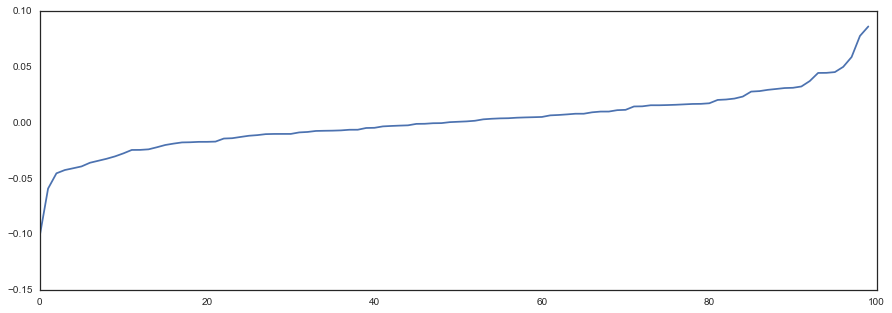

In [230]:
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_pca_channel_sorted[1][2])

In [ ]:
SelectedFeatures = [[] for i in range(1000)]
for i in range(1000):
    for k in range(12):

        SelectedFeatures[i] += [AllFeatures_pca_channel_sorted[i][k][j] for j in range(1,15,1)]
        SelectedFeatures[i] += [AllFeatures_pca_channel_sorted[i][k][j] for j in range(85,100,1)]

In [ ]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])

### III.2 Sélection des Peaks

In [176]:
AllFeatures_peaks_sorted = [[[]for k in range(12)]for i in range(1000)]
for id in range(1000):
    for k in range(12):
        AllFeatures_peaks_sorted[id][k] = list(sorted(AllFeatures_peaks[id][k]))

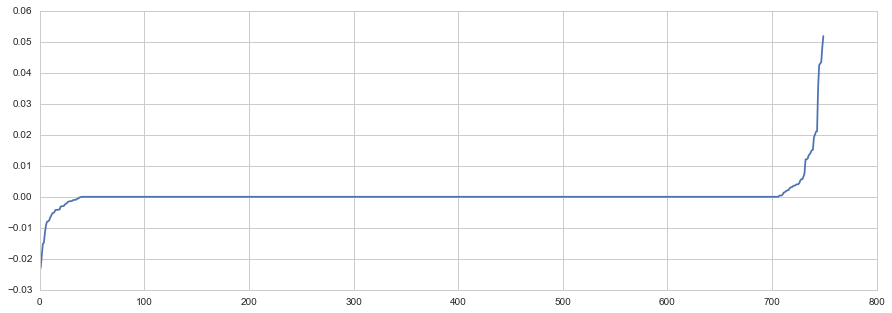

In [177]:
plt.figure(figsize = [15,5])
plt.plot(AllFeatures_peaks_sorted[1][2])


On peut extraire les peaks qui sont plus "grandes", c-à-d avec valeur absolue plus grands.

On essaye de retirer les information des peaks positives(resp. négatives) plus grandes et 2ème plus grandes.

c'est pourquoi on va prendre range(2,15,1) et range(735,748,1).



In [178]:
SelectedFeatures = [[] for i in range(1000)]
for i in range(1000):
    for k in range(12):
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in [2,9,15]]
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in [735,741,749]]

In [265]:
SelectedFeatures = [[] for i in range(1000)]
for i in range(1000):
    for k in range(12):
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in range(2,15,1)]
        SelectedFeatures[i] += [AllFeatures_peaks_sorted[i][k][j] for j in range(735,750,1)]

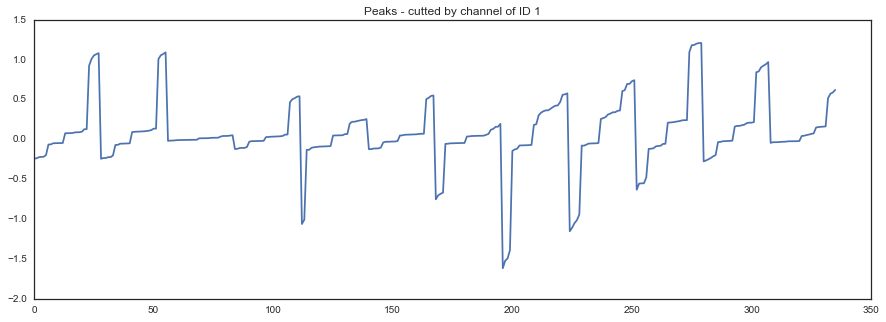

In [266]:
plt.figure(figsize = [15,5])
plt.plot(SelectedFeatures[1])
plt.title("Peaks - cutted by channel of ID 1")


# IV. Classifieurs

On considère les classifieur de type différente :

* GNB (Gaussian Naive BAyes)
* KNN (K plus proches voisins)
* SVM (Support Vector Machine)
* RF (Random Forest)
* MLP (Multi-Layer Perceptron)

Pour diminuer le temps de calculs, on fait un $découpage$ en 2:1 (apprentissage : test) pour les tester.

Et puis, on change la méthode de sélection des variables et les paramètres des classifieur par rapport les scores.

Finalement, on tire le classifieur avec la performance relativement bien et on fait $validation\ croisée$ pour ajuster les paramètres plus finement et avoir le score plus précis.

In [31]:
N_sep = len(lable)*2/3
sns.set_style("white")

### IV.1 Guaussian Naive Bayes (GNB)

Taux de Bien CLassés : 0.625748502994


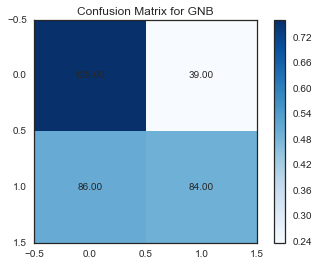

In [267]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB()
gnb.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
score_gnb = gnb.score(SelectedFeatures[N_sep:], lable[N_sep:])
print"Taux de Bien CLassés :", score_gnb

feat_pred_gnb = gnb.predict(SelectedFeatures[N_sep:])
PlotCM(lable[N_sep:],feat_pred_gnb,'GNB')

### IV.2 K Plus Proches Voisins (KNN)

Taux de Bien CLassés : 0.691616766467


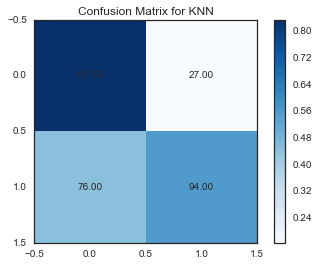

In [268]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors = 15, weights="uniform")
knn.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
score_knn = knn.score(SelectedFeatures[N_sep:], lable[N_sep:])
print"Taux de Bien CLassés :", score_knn
feat_pred_knn = knn.predict(SelectedFeatures[N_sep:])
PlotCM(lable[N_sep:],feat_pred_knn,'KNN')

### IV.3 Support Vector Machine (SVM)

Taux de Bien CLassés : 0.751497005988


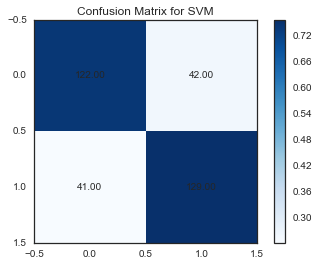

In [269]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘RBF!!!’ or 'poly'
svm.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
score_svm = svm.score(SelectedFeatures[N_sep:], lable[N_sep:])
print"Taux de Bien CLassés :", score_svm
feat_pred_svm = svm.predict(SelectedFeatures[N_sep:])
PlotCM(lable[N_sep:],feat_pred_svm,'SVM')

### IV.4 Random Forest (RF)

Taux de Bien CLassés : 0.844311377246


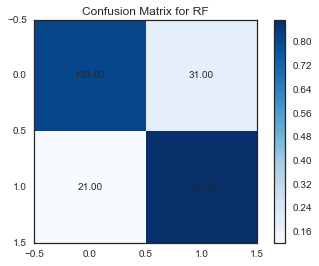

In [270]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=900)
RF.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
score_rf = RF.score(SelectedFeatures[N_sep:], lable[N_sep:])
print"Taux de Bien CLassés :", score_rf 
feat_pred_rf = RF.predict(SelectedFeatures[N_sep:])
PlotCM(lable[N_sep:],feat_pred_rf,'RF')

### IV.5 Multi-Layer Perceptron

Taux de Bien CLassés : 0.688622754491


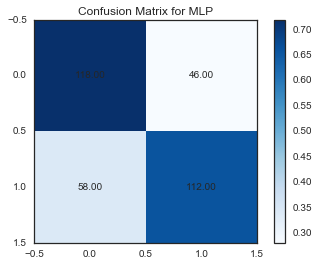

In [271]:
from MyMLP import *
nn = NeuralNetwork([len(SelectedFeatures[1]),40,1], 'logistic')
c = 0
feat_pred_mlp = [[] for i in range(1000-N_sep)]

nn.fit(SelectedFeatures[0:N_sep], lable[0:N_sep],learning_rate=0.1,epochs = 7000)
for i in range(N_sep,1000):
    feat_pred_mlp[i-N_sep] = int(nn.predict(SelectedFeatures[i])>0.5)
    if lable[i] == feat_pred_mlp[i-N_sep]:
        c+=1    
score_mlp = c/(1000.0-N_sep) 
print "Taux de Bien CLassés :", score_mlp
PlotCM(lable[N_sep:],feat_pred_mlp,'MLP')

### Comparaison

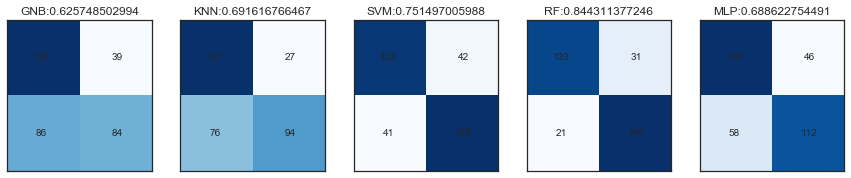

In [272]:
   fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharex='col', sharey='row')
fig.set_size_inches(15, 2.7)
PlotCM_sub(lable[N_sep:],feat_pred_gnb,score_gnb,"GNB",ax1)
PlotCM_sub(lable[N_sep:],feat_pred_knn,score_knn,"KNN",ax2)
PlotCM_sub(lable[N_sep:],feat_pred_svm,score_svm,"SVM",ax3)
PlotCM_sub(lable[N_sep:],feat_pred_rf,score_rf,"RF",ax4)
PlotCM_sub(lable[N_sep:],feat_pred_mlp,score_mlp,"MLP",ax5)

# V. Ajustement des Variables

En fait, on a fait les ajustements sur deux parties :

* sur les méthodes de sélection de variables
* sur les paramètres des classifieurs


où le premier cas est en général à la main.

Alors, ici on n'écrit que la procédure pour la deuxième partie.

Par la performance sur l'ensemble de test (par le découpage), on voit que c'est le RF classifieur qui marche le mieux.

Donc, On va ajuster les paramètres par la fonction GridSearchCV.

In [ ]:
from sklearn.grid_search import GridSearchCV
tuned_parameters = {'n_estimators': range(100,1000,100)}
RFGrid = GridSearchCV(RandomForestClassifier(), tuned_parameters,cv=5)
RFGrid.fit(SelectedFeatures[0:N_sep], lable[0:N_sep])
print"Taux de Bien CLassés :", RFGrid.score(SelectedFeatures[N_sep:], lable[N_sep:])
feat_pred_rfgrid = RF.predict(SelectedFeatures[N_sep:])
PlotCM(lable[N_sep:],feat_pred_rfgrid,'RFGrid')

# VI. Modèle Final et le Test par CV

Finalement, avant de mettre Ytest sur le site, on fait une validation croisée sur Xtrain et Ytrain pour avoir le taux de bien classés relativement raisonnable.

Donc, le modèle final pour nous est :

* $Collection\ des\ Variables$ : tous les peaks,(les points avec max-abs local)
* $Sélection\ des\ Variables$ : On ne prends que les peaks les plus grands et 2ème plus grands, positives et négative.
* $Classifieur$ : Random Forest CV(pour n_estimateur)

Estimation final du taux de bon classement est : 89% environ

Taux de bon classement sur challengedata est : 89.8%

In [162]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(GridRF, SelectedFeatures, lable, cv=10)
print(scores)
print "Taux de Bien CLassés :", (np.mean(scores))

[ 0.92079208  0.9009901   0.83        0.92        0.9         0.93        0.88
  0.88        0.87878788  0.84848485]
Taux de Bien CLassés : 0.888905490549


# VII. Annexe de l'Annexe : Fonctions Désignées pour le Projet. 

#### ECGs_funtions.py

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


#function for data importing
def DataImporting():
    'Data importing : Xtrain, Ytrain & Xtest'
    Xtrain = pd.read_csv('raw data/input_training.csv',sep = ',',header = 0)
    Ytrain = pd.read_csv('raw data/output_training.csv',sep = ';',header = 0)
    Xtest = pd.read_csv('raw data/input_testing.csv',sep = ',',header = 0)
    return Xtrain,Ytrain,Xtest

#function for data sampling
def DataSample(X,ID,index):
    'X:dataframe of input data'
    'Id = id, from 0 to 999'
    'index = index of channel, from 1 to 12'
    return X.iloc[ID,1+(index-1)*750:1+index*750] 

#function for ploting Confusion Matrix.
def PlotCM(lable,pred,title):
    'Plot confusion matrix for supervised classification'
    sns.set_style("white")
    cm = confusion_matrix(lable,pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
    plt.title('Confusion Matrix for '+ title)

    plt.colorbar()
    for y in range(2):
        for x in range(2):
            plt.text(x, y , '%.2f' % cm[y,x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
            

def PlotCM_sub(lable,pred,score,title,ax):
    
    'Plot confusion matrix for supervised classification'
    sns.set_style("white")
    cm = confusion_matrix(lable,pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
    ax.set_title(title + ':'+ str(score))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax.colorbar()
    for y in range(2):
        for x in range(2):
            ax.text(x, y , '%.0f' % cm[y,x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

def neighbour(newobj,listindex,threshold = 10):
    for obj in listindex:
        if np.abs(newobj-obj)<threshold:
            return True
#function for PeriodSplit

def PeriodSplit(wave,threshold =1.0/10):
    set_peak = [np.argmax(np.abs(wave[:300]))]
    max_peak = wave[set_peak[0]]
    for i in range(len(wave)):
        if np.abs(wave[i]-max_peak) <= 1.0/4*np.abs(max_peak) and neighbour(i,set_peak) != True :
            set_peak.append(i)
    num_peak = len(set_peak)     
    start_interval = range(np.min(set_peak))
    

    
    
    if num_peak == 1 or num_peak == 2 or num_peak>5:
        
        num_peak = 3     
        start_interval = range(50)
        
        
        
    period_interval = range(750/(num_peak+1),750/(num_peak-1),1)
    sd = [[[]for period in period_interval] for start in start_interval]
    for start in start_interval:
        for period in period_interval:
            if np.abs(wave[start])<threshold*np.abs(np.max(wave)) and start + period*2<750:
                sd[start][period-period_interval[0]] = np.std(wave[start:start+period]-wave[start+period:start+period*2])
            else:
                sd[start][period-period_interval[0]] = float('inf')

    sdlist = []
    for start in sd:
        sdlist += start
    start,period = np.argmin(sd)/len(period_interval),np.argmin(sd)%len(period_interval)+period_interval[0]
    
    print "number of peaks : ",num_peak
    print "start at :", start
    print 'period :', period
    return wave[start :start + period]



#### MyMLP.py

In [ ]:
import numpy as np

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2

def logistic(x):
    return 1/(1 + np.exp(-x))

def logistic_derivative(x):
    return logistic(x)*(1-logistic(x))

class NeuralNetwork:
    def __init__(self, layers, activation='tanh'):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        if activation == 'logistic':
            self.activation = logistic
            self.activation_deriv = logistic_derivative
        elif activation == 'tanh':
            self.activation = tanh
            self.activation_deriv = tanh_deriv

        self.weights = []
        for i in range(1, len(layers) - 1):
            self.weights.append((2*np.random.random((layers[i - 1] + 1, layers[i]
                                + 1))-1)*0.25)
        self.weights.append((2*np.random.random((layers[i] + 1, layers[i +
                            1]))-1)*0.25)
    def fit(self, X, y, learning_rate=0.2, epochs=10000):
        X = np.atleast_2d(X)
        temp = np.ones([X.shape[0], X.shape[1]+1])
        temp[:, 0:-1] = X  # adding the bias unit to the input layer
        X = temp
        y = np.array(y)

        for k in range(epochs):
            i = np.random.randint(X.shape[0])
            a = [X[i]]

            for l in range(len(self.weights)):
                a.append(self.activation(np.dot(a[l], self.weights[l])))
            error = y[i] - a[-1]
            deltas = [error * self.activation_deriv(a[-1])]

            for l in range(len(a) - 2, 0, -1): # we need to begin at the second to last layer
                deltas.append(deltas[-1].dot(self.weights[l].T)*self.activation_deriv(a[l]))
            deltas.reverse()
            for i in range(len(self.weights)):
                layer = np.atleast_2d(a[i])
                delta = np.atleast_2d(deltas[i])
                self.weights[i] += learning_rate * layer.T.dot(delta)
    def predict(self, x):
        x = np.array(x)
        temp = np.ones(x.shape[0]+1)
        temp[0:-1] = x
        a = temp
        for l in range(0, len(self.weights)):
            a = self.activation(np.dot(a, self.weights[l]))
        return a